In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [2]:
import os
import random
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain, product
from collections import defaultdict

### Prepare data

In [3]:
SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
              'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
              'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
              'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
              'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)

In [4]:
DOC_LEN = 5
SENT_FROM_LEN = 5
SENT_TO_LEN = 15

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_rand_sent_code(sem_type, sent_len):
    return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs
    
def batch_mixture(doc_a, doc_b, k):
    batch_x1, batch_x2, batch_y = [], [], []
    ys = [1,0,0,1]
    for _ in range(k):
        for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
            batch_x1.append(random.choice(da))
            batch_x2.append(random.choice(db))
            batch_y.append(ys[i])
    return batch(batch_x1), batch(batch_x2), np.array(batch_y)

def get_batch(n=40):
    if n%4!=0:
        raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    doc_a, doc_b, _, _ = get_mixture(type1, type2) # document mixtures and labels aren't germane here.
    (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), batch_y = batch_mixture(doc_a,doc_b,n//4)
    return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_y

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

input_x1 = tf.placeholder(tf.int32, [None, None], name='input_x1') # <max-time, batch-size>
input_x2 = tf.placeholder(tf.int32, [None, None], name='input_x2')
input_x1_length = tf.placeholder(tf.int32, [None], name='input_x1_length')
input_x2_length = tf.placeholder(tf.int32, [None], name='input_x2_length')
input_y  = tf.placeholder(tf.int32, [None], name='input_y')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

with tf.variable_scope('Embeddings'):
    embeddings = tf.get_variable('embeddings', [VOCAB_SIZE, EMB_SIZE], 
                                 initializer=tf.contrib.layers.xavier_initializer())
    input_x1_embedded = tf.nn.embedding_lookup(embeddings, input_x1) # <max-time, batch-size, emb-size>
    input_x2_embedded = tf.nn.embedding_lookup(embeddings, input_x2)

cell = MultiRNNCell([DropoutWrapper(LSTMCell(HID_SIZE),output_keep_prob=keep_prob)]*NUM_LAYERS) 

def run_lstm(cell, inputs, inputs_length): # lstm-out size *= 2 by bidirectionality.
    ((fw_outputs,bw_outputs), # <max-time, batch-size, hid-size>, attention later if needed.
     (fw_final_state,bw_final_state)) = ( # <batch-size, hid-size>
        tf.nn.bidirectional_dynamic_rnn(cell_fw=cell,
                                        cell_bw=cell,
                                        inputs=inputs,
                                        sequence_length=inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    return tf.concat([tf.concat([fw_state_tuple.h,bw_state_tuple.h], 1) # lstm-out size *= NUM_LAYERS by stacking.
                      for fw_state_tuple,bw_state_tuple in zip(fw_final_state,bw_final_state)], 1)
    
with tf.variable_scope('Bi-LSTM') as scope:
    final_state_x1 = run_lstm(cell, input_x1_embedded, input_x1_length)
    scope.reuse_variables() # both sentence inputs share the same weights.
    final_state_x2 = run_lstm(cell, input_x2_embedded, input_x2_length)
    
lstm_out_size = HID_SIZE * 2 * NUM_LAYERS
W_bi = tf.get_variable('W_bi', [lstm_out_size, lstm_out_size], initializer=tf.contrib.layers.xavier_initializer())
scores = tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(final_state_x1,W_bi),tf.transpose(final_state_x2))),name='scores')
predictions = tf.cast(tf.round(scores), tf.int32, name='predictions') 

with tf.name_scope('Loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses)

with tf.name_scope('Accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-5)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step, name='train_op')

sess.run(tf.global_variables_initializer())

In [140]:
NUM_EPOCHS = 50
NUM_BATCHES = 1000
VERBOSE = 100

loss_track, accuracy_track = [], []
for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    curr_loss_track, curr_accuracy_track = [], []
    for _ in range(NUM_BATCHES):
        batch_x1, batch_x1_length, batch_x2, batch_x2_length, batch_y = get_batch()
        fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
              input_x2:batch_x2, input_x2_length:batch_x2_length,
              input_y:batch_y,
              keep_prob:KEEP_PROB}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        curr_loss_track.append(loss_)
        curr_accuracy_track.append(accuracy_)
        if step%VERBOSE==0:
            print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
    print('\n')
    print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
    print('\n')    
    loss_track += curr_loss_track
    accuracy_track += curr_accuracy_track

In [7]:
# Save model

saver = tf.train.Saver()
save_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/"
save_path = save_dir + "stacked-bilstm-doc-mix-mock-00"
saver.save(sess, save_path)

'/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/stacked-bilstm-doc-mix-mock-00'

### Restore & Cont'd Training

In [10]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [141]:
# Import utilities

import random
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain, product

# Data generation block

SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
              'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
              'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
              'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
              'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)
    
DOC_LEN = 5
SENT_FROM_LEN = 5
SENT_TO_LEN = 15

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_rand_sent_code(sem_type, sent_len):
    return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs
    
def batch_mixture(doc_a, doc_b, k):
    batch_x1, batch_x2, batch_y = [], [], []
    ys = [1,0,0,1]
    for _ in range(k):
        for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
            batch_x1.append(random.choice(da))
            batch_x2.append(random.choice(db))
            batch_y.append(ys[i])
    return batch(batch_x1), batch(batch_x2), np.array(batch_y)

def get_batch(n=40):
    if n%4!=0:
        raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    doc_a, doc_b, _, _ = get_mixture(type1, type2) # document mixtures and labels aren't germane here.
    (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), batch_y = batch_mixture(doc_a,doc_b,n//4)
    return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_y
# Model restoration block

restore_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/"

sess = tf.Session()

saver = tf.train.import_meta_graph(restore_dir+'stacked-bilstm-doc-mix-mock-00.meta')
saver.restore(sess, tf.train.latest_checkpoint(restore_dir))
graph = tf.get_default_graph()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

input_x1 = graph.get_tensor_by_name('input_x1:0')
input_x2 = graph.get_tensor_by_name('input_x2:0')
input_x1_length = graph.get_tensor_by_name('input_x1_length:0')
input_x2_length = graph.get_tensor_by_name('input_x2_length:0')
input_y = graph.get_tensor_by_name('input_y:0')
keep_prob = graph.get_tensor_by_name('keep_prob:0')

scores = graph.get_tensor_by_name('scores:0')
predictions = graph.get_tensor_by_name('predictions:0')
loss = graph.get_tensor_by_name('Loss/Mean:0')
accuracy = graph.get_tensor_by_name('Accuracy/accuracy:0')
global_step = graph.get_tensor_by_name('global_step:0')
train_op = graph.get_tensor_by_name('train_op:0')

In [143]:
NUM_EPOCHS = 50
NUM_BATCHES = 1000
VERBOSE = 100

loss_track, accuracy_track = [], []
for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    curr_loss_track, curr_accuracy_track = [], []
    for _ in range(NUM_BATCHES):
        batch_x1, batch_x1_length, batch_x2, batch_x2_length, batch_y = get_batch()
        fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
              input_x2:batch_x2, input_x2_length:batch_x2_length,
              input_y:batch_y,
              keep_prob:KEEP_PROB}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        curr_loss_track.append(loss_)
        curr_accuracy_track.append(accuracy_)
        if step%VERBOSE==0:
            print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
    print('\n')
    print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
    print('\n')    
    loss_track += curr_loss_track
    accuracy_track += curr_accuracy_track

Epoch  1


  batch loss & accuracy at step 50100: <0.5032744407653809, 1.0>
  batch loss & accuracy at step 50200: <0.6931296586990356, 0.5>
  batch loss & accuracy at step 50300: <0.5077998638153076, 0.9749999642372131>
  batch loss & accuracy at step 50400: <0.5986820459365845, 0.75>
  batch loss & accuracy at step 50500: <0.5989395380020142, 0.75>
  batch loss & accuracy at step 50600: <0.5032198429107666, 1.0>
  batch loss & accuracy at step 50700: <0.5983470678329468, 0.75>
  batch loss & accuracy at step 50800: <0.6929119825363159, 0.5>
  batch loss & accuracy at step 50900: <0.5034803152084351, 1.0>
  batch loss & accuracy at step 51000: <0.5988529920578003, 0.75>


  epoch mean loss & accuracy: <0.5833315253257751, 0.7905250191688538>


Epoch  2


  batch loss & accuracy at step 51100: <0.597815752029419, 0.75>
  batch loss & accuracy at step 51200: <0.5980042219161987, 0.75>
  batch loss & accuracy at step 51300: <0.5982168316841125, 0.75>
  batch loss & accuracy at step 51400

  batch loss & accuracy at step 61000: <0.5513230562210083, 0.875>


  epoch mean loss & accuracy: <0.542340099811554, 0.926099956035614>


Epoch  12


  batch loss & accuracy at step 61100: <0.5195810794830322, 0.9749999642372131>
  batch loss & accuracy at step 61200: <0.5199826955795288, 0.949999988079071>
  batch loss & accuracy at step 61300: <0.7998103499412537, 0.4749999940395355>
  batch loss & accuracy at step 61400: <0.5045239329338074, 1.0>
  batch loss & accuracy at step 61500: <0.5379450917243958, 0.9000000357627869>
  batch loss & accuracy at step 61600: <0.5104652047157288, 1.0>
  batch loss & accuracy at step 61700: <0.5066905617713928, 1.0>
  batch loss & accuracy at step 61800: <0.5364363789558411, 0.875>
  batch loss & accuracy at step 61900: <0.5584036707878113, 0.824999988079071>
  batch loss & accuracy at step 62000: <0.781929612159729, 0.5000000596046448>


  epoch mean loss & accuracy: <0.5440362691879272, 0.9257500171661377>


Epoch  13


  batch loss & accurac

  batch loss & accuracy at step 71800: <0.5037268996238708, 1.0>
  batch loss & accuracy at step 71900: <0.5032444000244141, 1.0>
  batch loss & accuracy at step 72000: <0.5032317638397217, 1.0>


  epoch mean loss & accuracy: <0.5387770533561707, 0.9421250224113464>


Epoch  23


  batch loss & accuracy at step 72100: <0.8240206241607666, 0.42500001192092896>
  batch loss & accuracy at step 72200: <0.5042980909347534, 1.0>
  batch loss & accuracy at step 72300: <0.5035394430160522, 1.0>
  batch loss & accuracy at step 72400: <0.5234317183494568, 0.9500000476837158>
  batch loss & accuracy at step 72500: <0.5032566785812378, 1.0>
  batch loss & accuracy at step 72600: <0.5211626291275024, 0.9750000238418579>
  batch loss & accuracy at step 72700: <0.5039443969726562, 1.0>
  batch loss & accuracy at step 72800: <0.5033490657806396, 1.0>
  batch loss & accuracy at step 72900: <0.5195371508598328, 0.949999988079071>
  batch loss & accuracy at step 73000: <0.5034896731376648, 1.0>


  epoc

  batch loss & accuracy at step 82700: <0.5032255053520203, 1.0>
  batch loss & accuracy at step 82800: <0.5037341117858887, 1.0>
  batch loss & accuracy at step 82900: <0.5032244324684143, 1.0>
  batch loss & accuracy at step 83000: <0.5032044649124146, 1.0>


  epoch mean loss & accuracy: <0.5313560962677002, 0.9544249773025513>


Epoch  34


  batch loss & accuracy at step 83100: <0.5033372044563293, 1.0>
  batch loss & accuracy at step 83200: <0.5035825967788696, 1.0>
  batch loss & accuracy at step 83300: <0.5032381415367126, 1.0>
  batch loss & accuracy at step 83400: <0.5033731460571289, 1.0>
  batch loss & accuracy at step 83500: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 83600: <0.5033466815948486, 1.0>
  batch loss & accuracy at step 83700: <0.5034987926483154, 1.0>
  batch loss & accuracy at step 83800: <0.8132626414299011, 0.5>
  batch loss & accuracy at step 83900: <0.5032839179039001, 1.0>
  batch loss & accuracy at step 84000: <0.5032044649124146, 1.0>


 

  batch loss & accuracy at step 93800: <0.5033110976219177, 1.0>
  batch loss & accuracy at step 93900: <0.5032103657722473, 1.0>
  batch loss & accuracy at step 94000: <0.503207802772522, 1.0>


  epoch mean loss & accuracy: <0.5304788947105408, 0.9558749794960022>


Epoch  45


  batch loss & accuracy at step 94100: <0.5047842264175415, 1.0>
  batch loss & accuracy at step 94200: <0.5035998225212097, 1.0>
  batch loss & accuracy at step 94300: <0.5032224059104919, 1.0>
  batch loss & accuracy at step 94400: <0.503242552280426, 1.0>
  batch loss & accuracy at step 94500: <0.5033499598503113, 1.0>
  batch loss & accuracy at step 94600: <0.5032823085784912, 1.0>
  batch loss & accuracy at step 94700: <0.5033107995986938, 1.0>
  batch loss & accuracy at step 94800: <0.5034437775611877, 1.0>
  batch loss & accuracy at step 94900: <0.5032169818878174, 1.0>
  batch loss & accuracy at step 95000: <0.5034767389297485, 1.0>


  epoch mean loss & accuracy: <0.5318898558616638, 0.953574955463409

In [ ]:
# saver = tf.train.Saver()
# save_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/GROUPER-MOCK/"
# save_path = save_dir + "stacked-bilstm-doc-mix-mock-00"
# shutil.rmtree(save_dir)
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# saver.save(sess, save_path)

### Bi-LSTM + HAC

In [156]:
import numpy as np
import tensorflow as tf
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

class ClfHAC:
    
    def __init__(self, clf_dir, clf_filename):
        self.sess = tf.Session()
        saver = tf.train.import_meta_graph(clf_dir + clf_filename)
        saver.restore(self.sess, tf.train.latest_checkpoint(clf_dir))
        self.graph = tf.get_default_graph()
        self.input_x1 = self.graph.get_tensor_by_name('input_x1:0')
        self.input_x2 = self.graph.get_tensor_by_name('input_x2:0')
        self.input_x1_length = self.graph.get_tensor_by_name('input_x1_length:0')
        self.input_x2_length = self.graph.get_tensor_by_name('input_x2_length:0')
        self.input_y = self.graph.get_tensor_by_name('input_y:0')
        self.keep_prob = self.graph.get_tensor_by_name('keep_prob:0')

        self.scores = self.graph.get_tensor_by_name('scores:0')
        self.predictions = self.graph.get_tensor_by_name('predictions:0')
        self.loss = self.graph.get_tensor_by_name('Loss/Mean:0')
        self.accuracy = self.graph.get_tensor_by_name('Accuracy/accuracy:0')
        self.global_step = self.graph.get_tensor_by_name('global_step:0')
        self.train_op = self.graph.get_tensor_by_name('train_op:0')
        
        
    def dist(self, x1, x2):
        x1, x1_len = batch([x1])
        x2, x2_len = batch([x2])
        fd = {self.input_x1:x1, self.input_x1_length:x1_len,
              self.input_x2:x2, self.input_x2_length:x2_len,
              self.keep_prob:1.0}
        conf = self.sess.run(self.scores, feed_dict=fd)
        return 1-conf[0]
    
    def evaluate(self, doc_mix, doc_lbs, method='average', plot=True):
        doc_mix_sq, _ = batch(doc_mix)
        doc_mix_sq = doc_mix_sq.T
        doc_mix_clust = linkage(doc_mix_sq, method=method, metric=self.dist)
        # evaluate by class-based prec/rec/f1
        doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust') # predicted assignments
        eval_input = clust_to_eval_input(doc_prd, doc_lbs)
        prec, rec = cb_prec(*eval_input), cb_rec(*eval_input)
        f1 = cb_f1(prec, rec)
        if plot:
            print('Class-based clustering evaluation:')
            print('Precision = {} | Recall = {} | F1 = {}'.format(prec,rec,f1))
            print('\n')
            plt.figure(figsize=(25, 10))
            plt.title('Hierarchical Clustering Dendrogram')
            plt.xlabel('sample index')
            plt.ylabel('distance')
            dendrogram(
                doc_mix_clust,
                leaf_rotation=90.,  # rotates the x axis labels
                leaf_font_size=15.,  # font size for the x axis labels
            )
            plt.show() 
            print('True | Pred | Sentence')
            for label,pred_label,code in zip(doc_lbs,doc_prd,doc_mix):
                print('{}    | {}    | {}'.format(label,pred_label,to_sent(code)))
            print('\n')
        else:
            return doc_mix_clust, prec, rec, f1
        
        
def clust_to_eval_input(pred_clust, true_clust):
    pred_ass2cls, pred_cls2ass = [], defaultdict(list)
    true_ass2cls, true_cls2ass = [], defaultdict(list)
    for item_id,(pred_ass,true_ass) in enumerate(zip(pred_clust,true_clust)):
        pred_ass2cls.append((item_id,pred_ass))
        true_ass2cls.append((item_id,true_ass))
        pred_cls2ass[pred_ass].append(item_id)
        true_cls2ass[true_ass].append(item_id)
    pred_ass2cls = dict(pred_ass2cls)
    true_ass2cls = dict(true_ass2cls)
    return pred_ass2cls, pred_cls2ass, true_ass2cls, true_cls2ass

def cb(source_a2c, source_c2a, target_a2c, target_c2a):
    prec_num = prec_denom = 0
    for _,ass in source_c2a.items():
        card_ass = len(ass)
        mem_cls = set()
        for elem in ass:
            for t_elem,cls in target_a2c.items():
                if elem==t_elem:
                    mem_cls.add(cls)
        prec_num += card_ass - len(mem_cls)
        prec_denom += card_ass - 1
    return prec_num / prec_denom   

def cb_prec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(p_a2c, p_c2a, t_a2c, t_c2a)

def cb_rec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(t_a2c, t_c2a, p_a2c, p_c2a)
    
def cb_f1(prec, rec):
    return (2*rec*prec) / (rec+prec)
    

In [157]:
restore_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/"
restore_filename = 'stacked-bilstm-doc-mix-mock-00.meta'

In [158]:
clf_hac = ClfHAC(restore_dir, restore_filename)

Class-based clustering evaluation:
Precision = 0.875 | Recall = 0.875 | F1 = 0.875




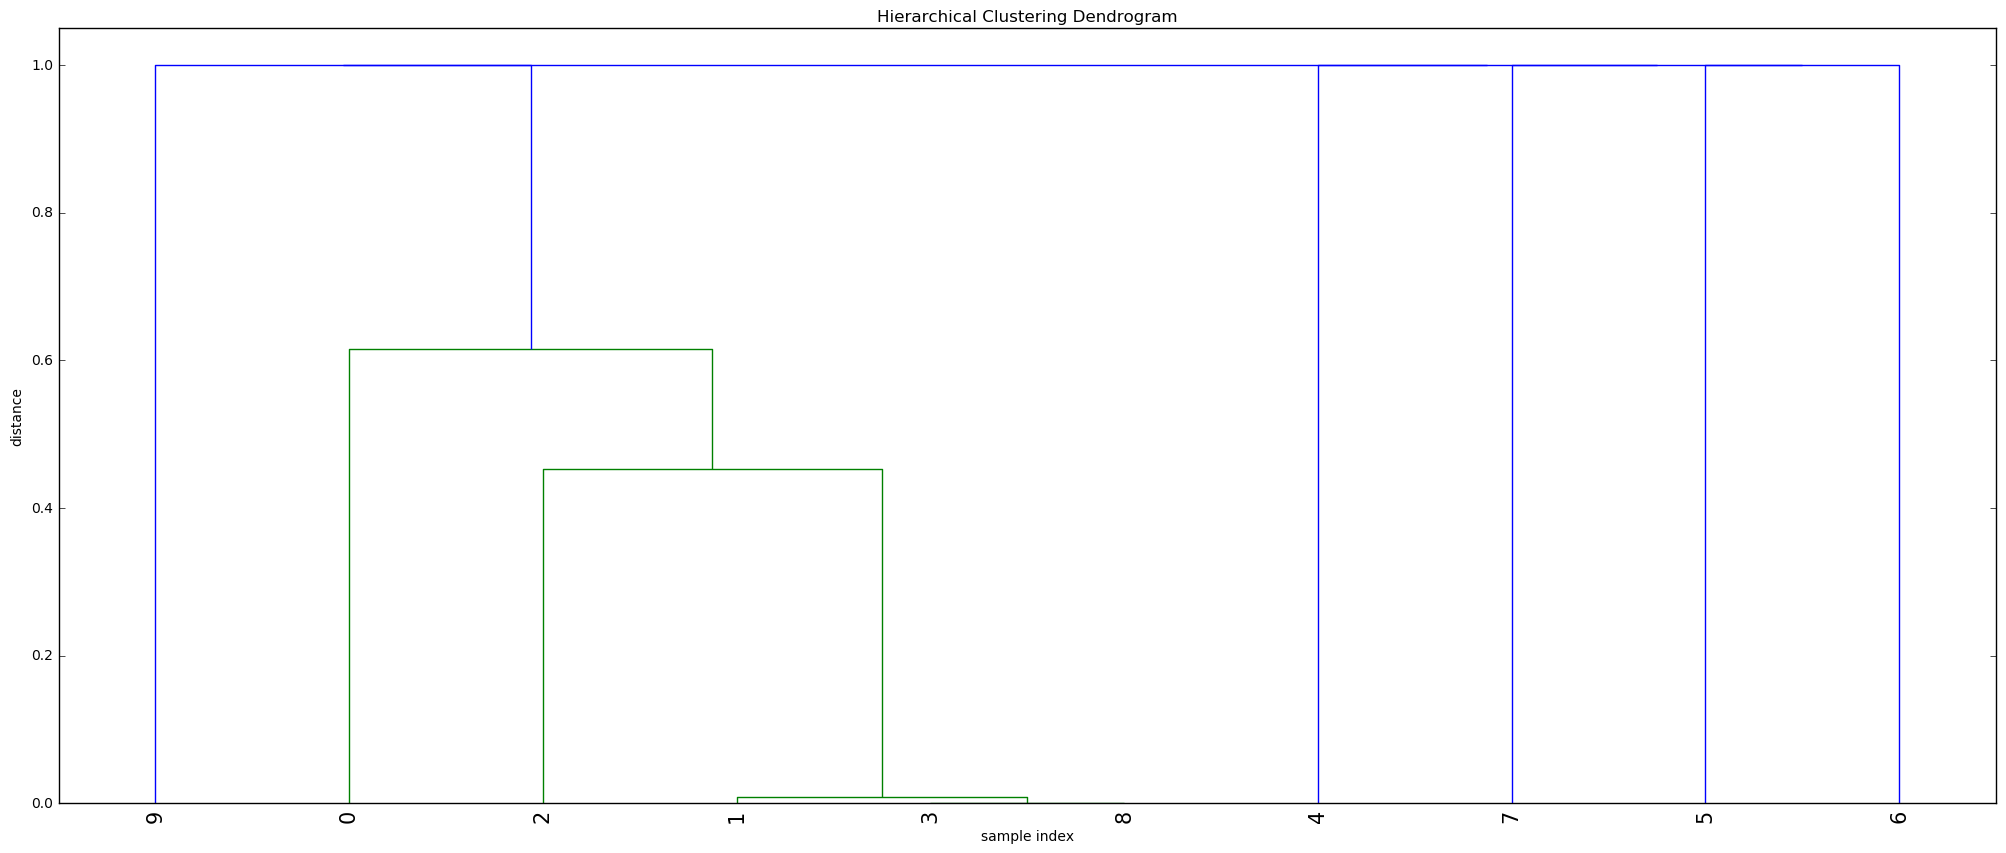

True | Pred | Sentence
0    | 1    | ['pig', 'share2', 'cat', 'deer', 'dog']
0    | 1    | ['dog', 'pig', 'pig', 'share1', 'cat', 'deer', 'share2']
0    | 1    | ['pig', 'share1', 'share2', 'cat', 'share1', 'share1', 'deer']
0    | 1    | ['pig', 'horse', 'pig', 'share1', 'share2', 'dog', 'horse']
1    | 2    | ['car', 'car', 'share2', 'share1', 'bus', 'share2', 'train', 'share1', 'bus', 'bus', 'bus', 'bike', 'bike']
1    | 2    | ['bike', 'share2', 'bus', 'train', 'motorcycle']
1    | 2    | ['bike', 'motorcycle', 'bike', 'car', 'train', 'bike', 'car', 'car', 'train', 'bike', 'car', 'share2', 'share1', 'bike']
1    | 2    | ['train', 'bus', 'train', 'train', 'bus', 'motorcycle', 'bike', 'share1', 'share2', 'bike', 'car', 'share2']
0    | 1    | ['share2', 'dog', 'deer', 'deer', 'share1', 'share1', 'deer', 'dog', 'deer', 'horse', 'share2']
1    | 1    | ['bike', 'bus', 'train', 'car', 'bus', 'bus', 'bus', 'train', 'car', 'motorcycle']




In [159]:
# da,db,dm,dl = get_mixture('ANIMAL', 'VEHICLE')
clf_hac.evaluate(dm, dl)

In [160]:
# # Evaluating with randomly generated documents

NUM_DOCS = 1000

def get_scores_for_rand_doc_mix(clf): # clf: a ClfHAC object.
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
#     print(type1, type2)
    _,_,dm,dl = get_mixture(type1, type2) # document a,b don't play into evaluation here.
    _, prec, rec, f1 = clf.evaluate(dm, dl, plot=False)
    return prec, rec, f1

precs,recs,f1s = [],[],[]
for i in range(NUM_DOCS):
    prec,rec,f1 = get_scores_for_rand_doc_mix(clf_hac)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    if i%10==0:
        print('Average Prec/Rec/F1 at {} = {}/{}/{}'.format(i+1,np.mean(precs),np.mean(recs),np.mean(f1s)))

Average Prec/Rec/F1 at 1 = 0.875/0.875/0.875
Average Prec/Rec/F1 at 11 = 0.9204545454545454/0.9204545454545454/0.9204545454545454
Average Prec/Rec/F1 at 21 = 0.9285714285714286/0.9285714285714286/0.9285714285714286
Average Prec/Rec/F1 at 31 = 0.9435483870967742/0.9435483870967742/0.9435483870967742
Average Prec/Rec/F1 at 41 = 0.9329268292682927/0.9329268292682927/0.9329268292682927
Average Prec/Rec/F1 at 51 = 0.9362745098039216/0.9362745098039216/0.9362745098039216
Average Prec/Rec/F1 at 61 = 0.9282786885245902/0.9282786885245902/0.9282786885245902
Average Prec/Rec/F1 at 71 = 0.9278169014084507/0.9278169014084507/0.9278169014084507
Average Prec/Rec/F1 at 81 = 0.9243827160493827/0.9243827160493827/0.9243827160493827
Average Prec/Rec/F1 at 91 = 0.9230769230769231/0.9230769230769231/0.9230769230769231
Average Prec/Rec/F1 at 101 = 0.9195544554455446/0.9195544554455446/0.9195544554455446
Average Prec/Rec/F1 at 111 = 0.9177927927927928/0.9177927927927928/0.9177927927927928
Average Prec/Rec/F

Average Prec/Rec/F1 at 971 = 0.9146498455200824/0.9146498455200824/0.9146498455200824
Average Prec/Rec/F1 at 981 = 0.9147553516819572/0.9147553516819572/0.9147553516819572
Average Prec/Rec/F1 at 991 = 0.9144803229061554/0.9144803229061554/0.9144803229061554


Class-based clustering evaluation:
Precision = 0.75 | Recall = 0.75 | F1 = 0.75




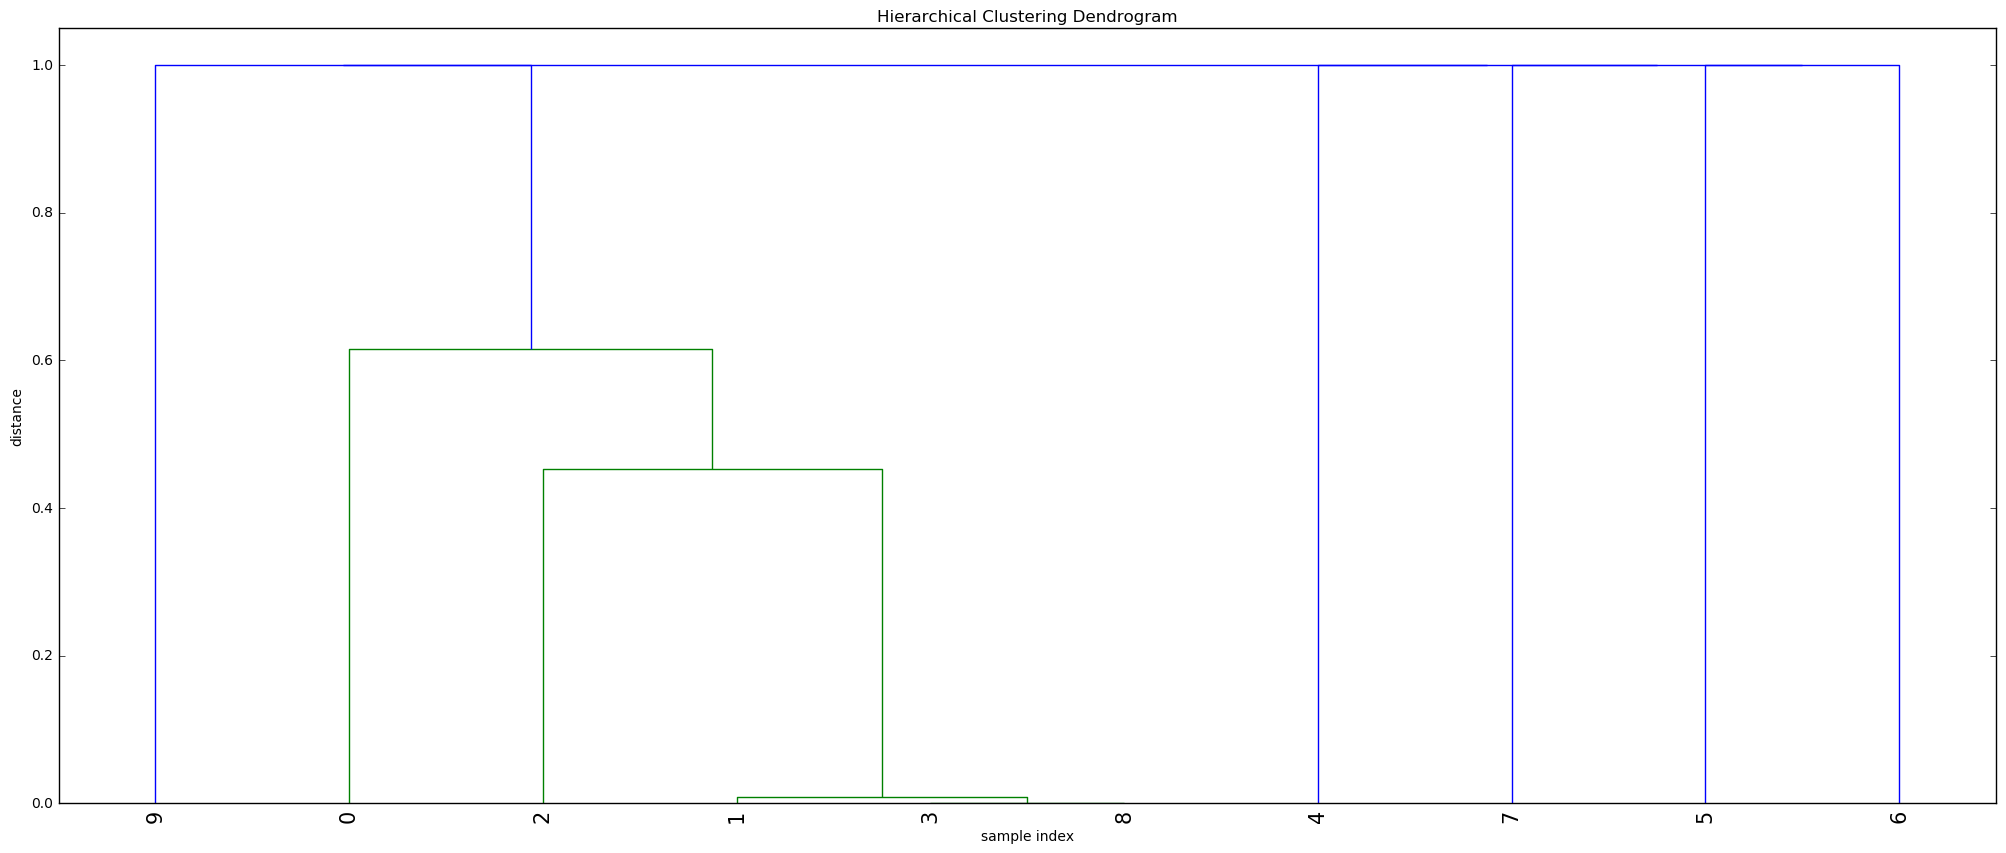

True | Pred | Sentence
0    | 2    | ['pig', 'share2', 'cat', 'deer', 'dog']
0    | 2    | ['dog', 'pig', 'pig', 'share1', 'cat', 'deer', 'share2']
0    | 1    | ['pig', 'share1', 'share2', 'cat', 'share1', 'share1', 'deer']
0    | 1    | ['pig', 'horse', 'pig', 'share1', 'share2', 'dog', 'horse']
1    | 1    | ['car', 'car', 'share2', 'share1', 'bus', 'share2', 'train', 'share1', 'bus', 'bus', 'bus', 'bike', 'bike']
1    | 1    | ['bike', 'share2', 'bus', 'train', 'motorcycle']
1    | 2    | ['bike', 'motorcycle', 'bike', 'car', 'train', 'bike', 'car', 'car', 'train', 'bike', 'car', 'share2', 'share1', 'bike']
1    | 1    | ['train', 'bus', 'train', 'train', 'bus', 'motorcycle', 'bike', 'share1', 'share2', 'bike', 'car', 'share2']
0    | 2    | ['share2', 'dog', 'deer', 'deer', 'share1', 'share1', 'deer', 'dog', 'deer', 'horse', 'share2']
1    | 2    | ['bike', 'bus', 'train', 'car', 'bus', 'bus', 'bus', 'train', 'car', 'motorcycle']




In [153]:
da,db,dm,dl = get_mixture('ANIMAL', 'VEHICLE')
clf_hac.evaluate(dm, dl)

In [138]:
# _,_,dm2,dl2 = get_mixture('ANIMAL', 'VEHICLE')
# clf_hac.evaluate(dm2, dl2)